# COVID19 evolution analysis

#### data loading

In [98]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.expanduser(os.path.join('~','Documents', 'projects', 'coronavirus')))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src import tools
import plotly.express as px
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from src.data_downloader import DATA_REPOS, download_from_repo
from matplotlib.ticker import ScalarFormatter
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### update data from repos

In [99]:
dest=os.path.expanduser(os.path.join('~','Documents', 'projects', 'coronavirus', 'data'))

In [100]:
DATA_REPOS['italy']['streams']

['/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
 '/dati-regioni/dpc-covid19-ita-regioni.csv',
 '/dati-province/dpc-covid19-ita-province.csv']

In [101]:
download_from_repo(DATA_REPOS['world']['url'], filenames=DATA_REPOS['world']['streams'], dest=dest)

last commit  2020-04-01 02:08:36


In [102]:
download_from_repo(DATA_REPOS['italy']['url'], filenames=DATA_REPOS['italy']['streams'], dest=dest)

last commit  2020-04-01 18:19:19


### load data

In [103]:
df_naz = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
reg = pd.read_csv('../data/dpc-covid19-ita-regioni.csv')
prov = pd.read_csv('../data/dpc-covid19-ita-province.csv').drop('stato',1)
df_naz.index = pd.to_datetime(df_naz.index)
reg['data'] = pd.to_datetime(reg['data'])
prov['data'] = pd.to_datetime(prov['data'])
df_world_confirmed = pd.read_csv('../data/time_series_covid19_confirmed_global.csv')
df_world_deaths = pd.read_csv('../data/time_series_covid19_deaths_global.csv')
df_world_recovered = pd.read_csv('../data/time_series_covid19_recovered_global.csv')
populations = pd.read_csv('../data/API_SP.POP.TOTL_DS2_en_csv_v2.csv', skiprows=4, engine='python').set_index('Country Name')['2018']
df_world_confirmed['pop'] = df_world_confirmed['Country/Region'].map(populations)
df_world_deaths['pop'] = df_world_deaths['Country/Region'].map(populations)
df_world_recovered['pop'] = df_world_recovered['Country/Region'].map(populations)
df_naz = tools.add_extra_features(df_naz)
regions = reg.groupby('denominazione_regione')
df_reg = {}
for item in regions.groups:
    df_reg[item] = tools.add_extra_features(regions.get_group(item)).replace((np.inf, np.nan), 0)
provinces = prov.groupby('sigla_provincia')
df_prov = pd.DataFrame()
for item in provinces.groups:
    df_prov = pd.concat((df_prov,tools.add_extra_features(provinces.get_group(item)).replace((np.inf, np.nan), 0)),0)

In [104]:
df_naz.tail()

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,delta_totale_casi,%delta_totale_casi,growth_factor,delta_dimessi_guariti,%delta_dimessi_guariti,delta_deceduti,%delta_deceduti,deceduti_su_tot,deceduti_su_dimessi
data,,,,,,,,,,,,,,,,,,,,,,
03/28/2020,26676,3856,30532,39533,70065,3651,5974,12384,10023,92472,429526,NaN,NaN,5974.0,0.069065,1.002517,1434.0,0.130959,889.0,0.097329,0.108390,0.809351
03/29/2020,27386,3906,31292,42588,73880,3815,5217,13030,10779,97689,454030,pd-IT-0009,pd-EN-0009,5217.0,0.056417,0.873284,646.0,0.052164,756.0,0.075427,0.110340,0.827245
03/30/2020,27795,3981,31776,43752,75528,1648,4050,14620,11591,101739,477359,NaN,NaN,4050.0,0.041458,0.776308,1590.0,0.122026,812.0,0.075332,0.113929,0.792818
03/31/2020,28192,4023,32215,45420,77635,2107,4053,15729,12428,105792,506968,NaN,NaN,4053.0,0.039837,1.000741,1109.0,0.075855,837.0,0.072211,0.117476,0.790133
04/01/2020,28403,4035,32438,48134,80572,2937,4782,16847,13155,110574,541423,NaN,NaN,4782.0,0.045202,1.179867,1118.0,0.071079,727.0,0.058497,0.118970,0.780851


In [105]:
date_cols = [item for item in df_world_confirmed.columns if '/20' in item]

In [106]:
df_world_confirmed.pivot_table(index='Country/Region', values=date_cols).T.tail()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cuba,Cyprus,Czechia,Denmark,Diamond Princess,Djibouti,Dominica,Dominican Republic,Ecuador,Egypt,El Salvador,Equatorial Guinea,Eritrea,Estonia,Eswatini,Ethiopia,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Grenada,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Holy See,Honduras,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,"Korea, South",Kosovo,Kuwait,Kyrgyzstan,Laos,Latvia,Lebanon,Liberia,Libya,Liechtenstein,Lithuania,Luxembourg,MS Zaandam,Madagascar,Malaysia,Maldives,Mali,Malta,Mauritania,Mauritius,Mexico,Moldova,Monaco,Mongolia,Montenegro,Morocco,Mozambique,Namibia,Nepal,Netherlands,New Zealand,Nicaragua,Niger,Nigeria,North Macedonia,Norway,Oman,Pakistan,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Romania,Russia,Rwanda,Saint Kitts and Nevis,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
3/5/20,1.0,0.0,12.0,1.0,0.0,0.0,1.0,1.0,6.875,41.0,6.0,0.0,55.0,0.0,0.0,6.0,50.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.466667,0.0,0.0,4.0,2440.515152,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,12.0,3.666667,706.0,0.0,0.0,1.0,13.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,38.0,0.0,0.0,4.0,482.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,34.0,30.0,2.0,3513.0,35.0,6.0,20.0,3858.0,0.0,360.0,1.0,0.0,0.0,6088.0,0.0,58.0,0.0,0.0,1.0,16.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,20.50,3.0,0.0,0.0,1.0,1.0,87.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,8.0,6.0,4.0,0.0,0.0,0.0,0.0,21.0,5.0,4.0,0.0,0.0,0.0,117.0,0.0,2.0,0.0,1.0,259.0,1.0,0.0,0.0,94.0,114.0,0.0,44.0,0.0,47.0,0.0,0.0,0.0,1.0,0.0,217.0,0.0,1.0,29.0,11.6,0.0,0.0,0.0,16.0,4.0,0.0,0.0
3/6/20,1.0,0.0,17.0,1.0,0.0,0.0,2.0,1.0,7.500,55.0,6.0,0.0,60.0,0.0,0.0,6.0,109.0,0.0,0.0,1.0,0.0,2.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.266667,0.0,0.0,4.0,2445.151515,1.0,0.0,0.0,1.0,0.0,11.0,0.0,0.0,18.0,8.000000,706.0,0.0,0.0,2.0,13.0,15.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,15.0,65.6,0.0,0.0,4.0,670.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,43.0,31.0,4.0,4747.0,40.0,18.0,37.0,4636.0,0.0,420.0,1.0,0.0,0.0,6593.0,0.0,58.0,0.0,0.0,1.0,22.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,83.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,32.00,4.0,0.0,0.0,1.0,3.0,108.0,16.0,6.0,0.0,0.0,0.0,1.0,5.0,5.0,13.0,8.0,9.0,13.0,0.0,0.0,0.0,0.0,21.0,5.0,4.0,1.0,0.0,0.0,130.0,1.0,7.0,0.0,1.0,400.0,1.0,0.0,0.0,101.0,214.0,0.0,45.0,0.0,48.0,0.0,1.0,0.0,1.0,0.0,262.0,0.0,1.0,29.0,16.4,0.0,0.0,0.0,16.0,7.0,0.0,0.0
3/7/20,1.0,0.0,17.0,1.0,0.0,0.0,8.0,1.0,7.875,79.0,9.0,0.0,85.0,0.0,0.0,6.0,169.0,0.0,0.0,1.0,0.0,3.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.600000,0.0,0.0,4.0,2447.575758,1.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,19.0,8.000000,706.0,0.0,0.0,2.0,13.0,15.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,15.0,95.9,0.0,0.0,4.0,799.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,50.0,34.0,4.0,5823.0,54.0,18.0,43.0,5883.0,0.0,461.0,1.0,0.0,0.0,7041.0,0.0,61.0,0.0,0.0,1.0,22.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,93.0,0.0,0.0,3.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,47.00,5.0,0.0,0.0,1.0,3.0,147.0,16.0,6.0,0.0,0.0,0.0,1.0,6.0,5.0,20.0,8.0,9.0,13.0,0.0,0.0,0.0,0.0,23.0,5.0,4.0,1.0,0.0,0.0,138.0,1.0,7.0,0.0,1.

## Italy

### diffusion heatmap for provinces

In [107]:
col = 'totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov[df_prov.index==df_prov.index.max()].index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

In [108]:
col = '%delta_totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov.index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

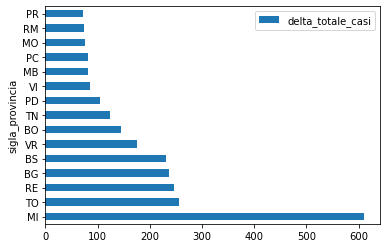

In [109]:
df_prov[df_prov.index==df_prov.index.max()][['sigla_provincia', 'delta_totale_casi']].sort_values(by='delta_totale_casi', ascending=False)[:15].set_index('sigla_provincia').plot(kind='barh')

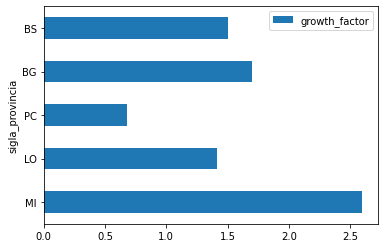

In [110]:
df_prov[df_prov.index==df_prov.index.max()][['sigla_provincia', 'growth_factor']].set_index('sigla_provincia').loc[['MI','LO','PC','BG','BS']].plot(kind='barh')

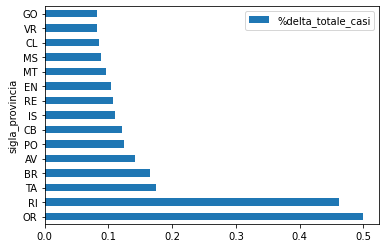

In [111]:
df_prov[df_prov.index==df_prov.index.max()][['sigla_provincia', '%delta_totale_casi']].sort_values(by='%delta_totale_casi', ascending=False)[:15].set_index('sigla_provincia').plot(kind='barh')

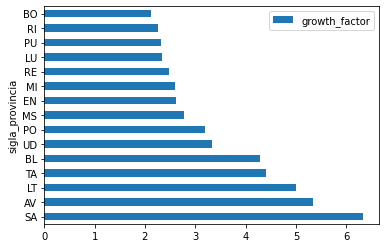

In [112]:
df_prov[df_prov.index==df_prov.index.max()][['sigla_provincia', 'growth_factor']].sort_values(by='growth_factor', ascending=False)[:15].set_index('sigla_provincia').plot(kind='barh')

### National evolution

TypeError: no numeric data to plot

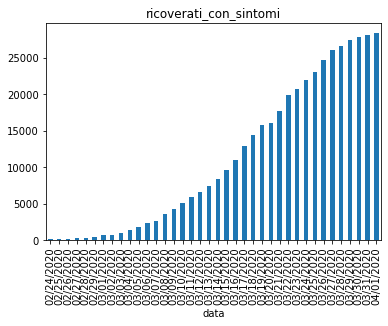

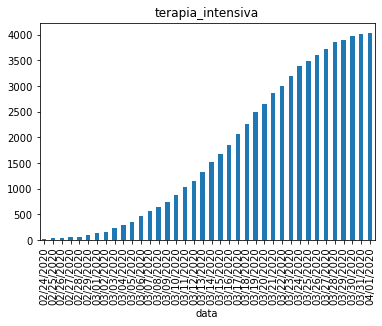

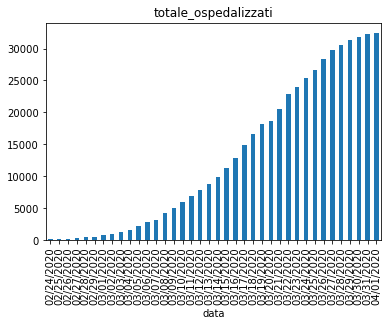

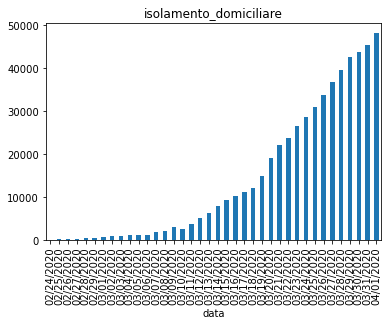

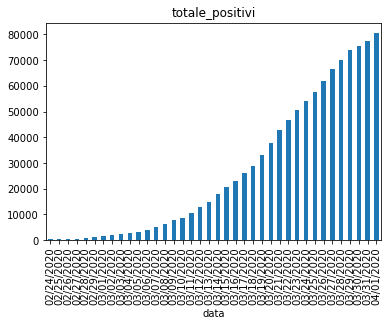

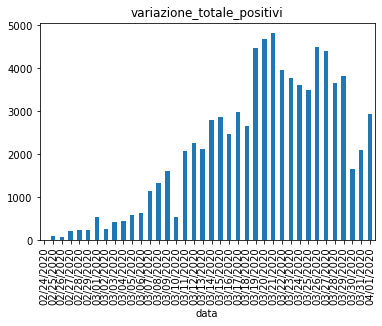

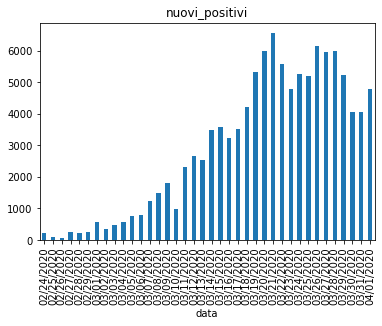

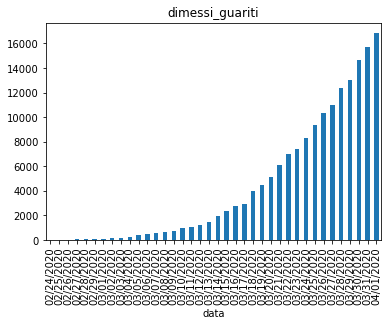

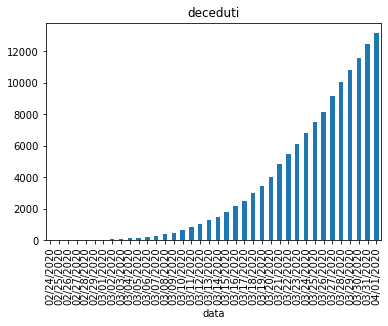

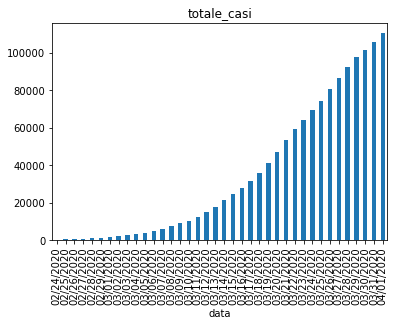

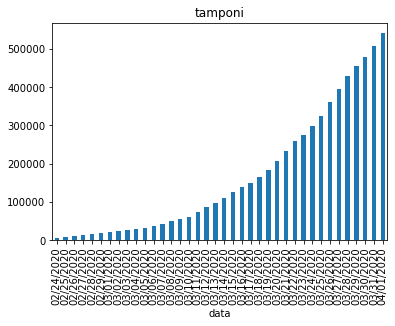

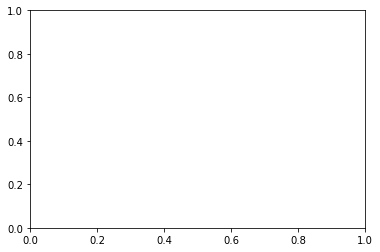

In [113]:
for col in df_naz.columns:
    plt.figure()
    df_naz[col].plot(kind='bar', title=col)    

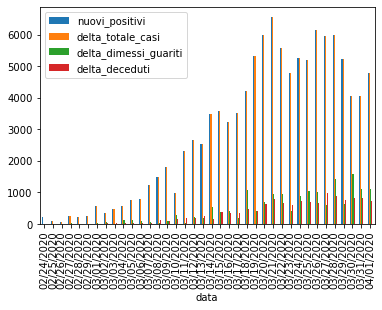

In [114]:
df_naz[['nuovi_positivi', 'delta_totale_casi','delta_dimessi_guariti','delta_deceduti']].plot(kind='bar')

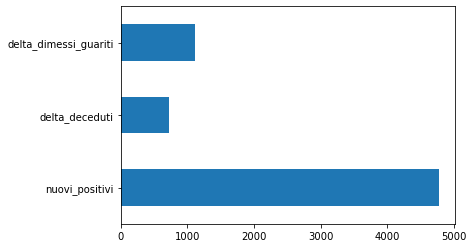

In [115]:
df_naz[['nuovi_positivi', 'delta_deceduti','delta_dimessi_guariti']].iloc[-1].plot(kind='barh')

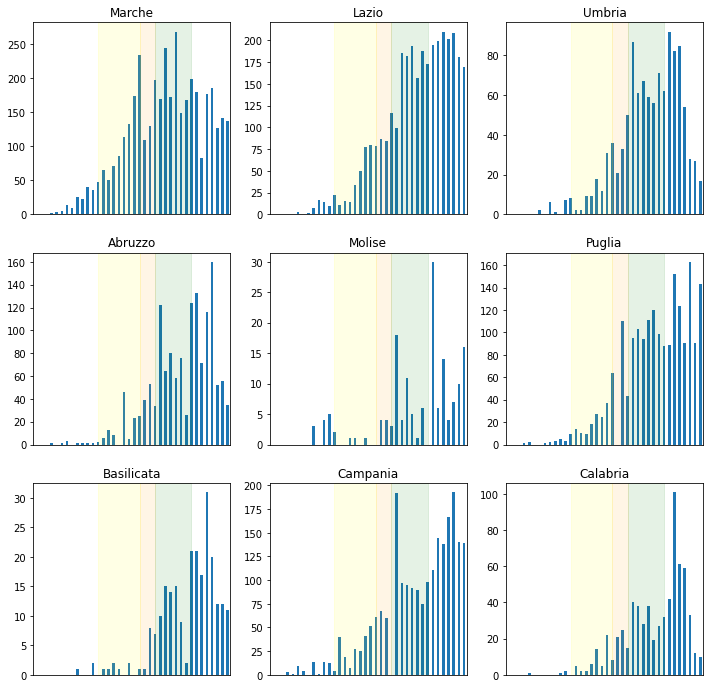

In [116]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12))#, sharex=True, sharey=True)
for x, (ax, reg) in enumerate(zip(axes.flatten(),['Marche','Lazio','Umbria',
        'Abruzzo','Molise','Puglia','Basilicata', 'Campania','Calabria'])):
    
    df_reg[reg]['delta_totale_casi'].plot(kind='bar', ax=ax)
    ax.axvspan(12, 20, alpha=0.1, color='yellow')
    ax.axvspan(20, 23, alpha=0.1, color='orange')
    ax.axvspan(23, 30, alpha=0.1, color='green')
    ax.get_xaxis().set_visible(False)
    ax.set_title(reg)

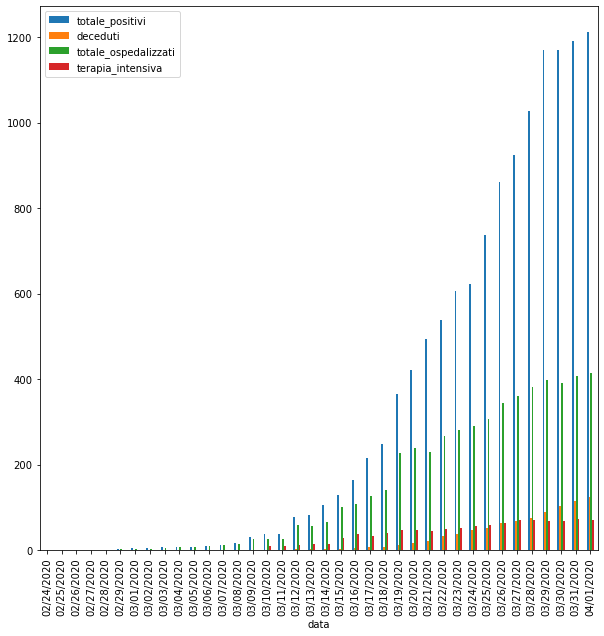

In [117]:
df_reg['Abruzzo'][['totale_positivi', 'deceduti', 'totale_ospedalizzati', 'terapia_intensiva']].plot(kind='bar', figsize=(10,10))

### Logistic model evolution

### National Analysis

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:146: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



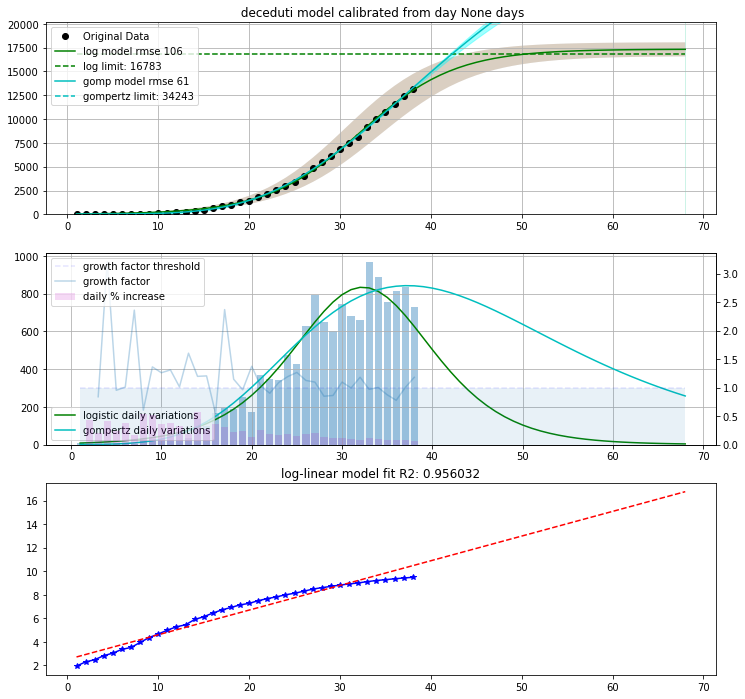

next day prediction for log model:  13596
next day prediction for gomp model:  14096
data
03/28/2020    10023
03/29/2020    10779
03/30/2020    11591
03/31/2020    12428
04/01/2020    13155
Name: deceduti, dtype: int64


In [118]:
tools.plot_model(df_naz, 'deceduti', backward_fit=None, backward_fit_gomp=None, stdev=2, forward_look=30, plotdifferential=True, plotlimit=True, show_log=True, show_gomp=True)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:146: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



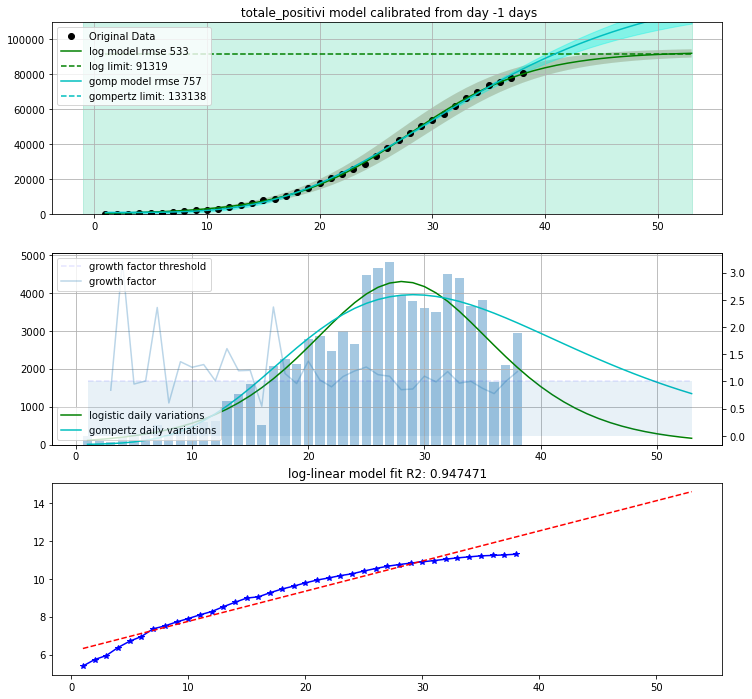

next day prediction for log model:  82060
next day prediction for gomp model:  86095
data
03/28/2020    70065
03/29/2020    73880
03/30/2020    75528
03/31/2020    77635
04/01/2020    80572
Name: totale_positivi, dtype: int64


In [119]:
tools.plot_model(df_naz, 'totale_positivi', backward_fit=-1, stdev=2, forward_look=15, plotdifferential=True, plotlimit=True, show_pol=False, show_exp=False)

c:\anaconda3\envs\coronavirus\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:27: RuntimeWarning:

overflow encountered in exp

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:27: RuntimeWarning:

overflow encountered in multiply

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:27: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:27: RuntimeWarning:

invalid value encountered in multiply

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:27: RuntimeWarning:

invalid value encountered in add

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:27: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\to

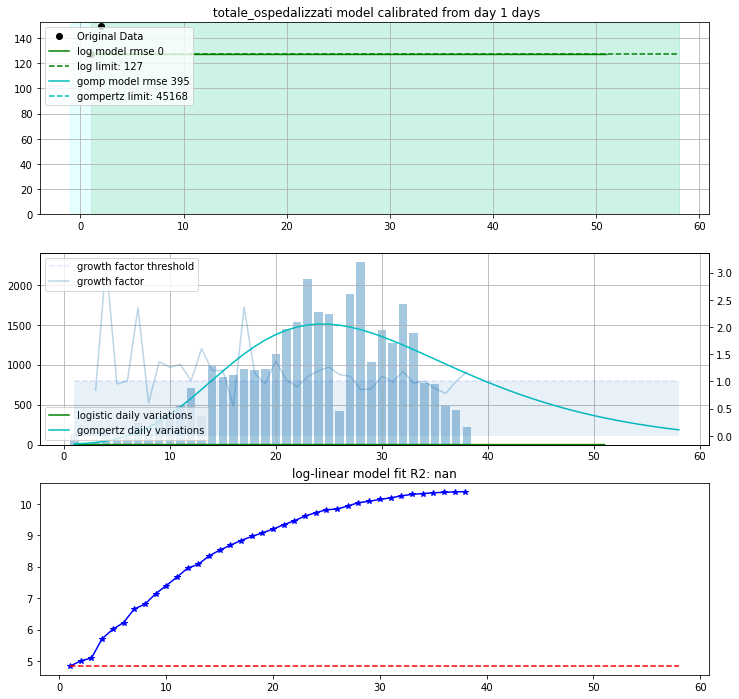

next day prediction for log model:  127
next day prediction for gomp model:  35025
data
03/28/2020    30532
03/29/2020    31292
03/30/2020    31776
03/31/2020    32215
04/01/2020    32438
Name: totale_ospedalizzati, dtype: int64


In [126]:
tools.plot_model(df_naz, 'totale_ospedalizzati', backward_fit=1, forward_look=20, plotlimit=True, show_pol=False, show_exp=False)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:146: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



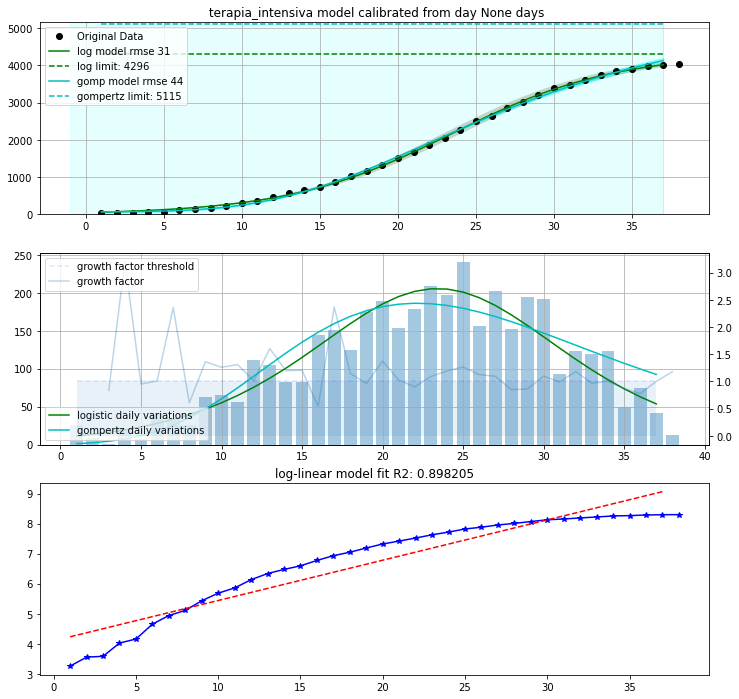

next day prediction for log model:  4112
next day prediction for gomp model:  4303
data
03/28/2020    3856
03/29/2020    3906
03/30/2020    3981
03/31/2020    4023
04/01/2020    4035
Name: terapia_intensiva, dtype: int64


In [127]:
tools.plot_model(df_naz, 'terapia_intensiva', backward_fit=None, forward_look=-1, plotlimit=True, show_pol=False, show_exp=False)

### Regional Analysis

In [128]:
region='Lombardia'

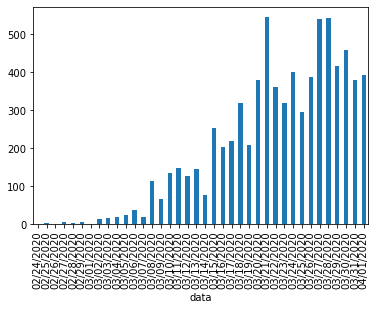

In [129]:
df_reg['Lombardia']['delta_deceduti'].plot(kind='bar')

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:146: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



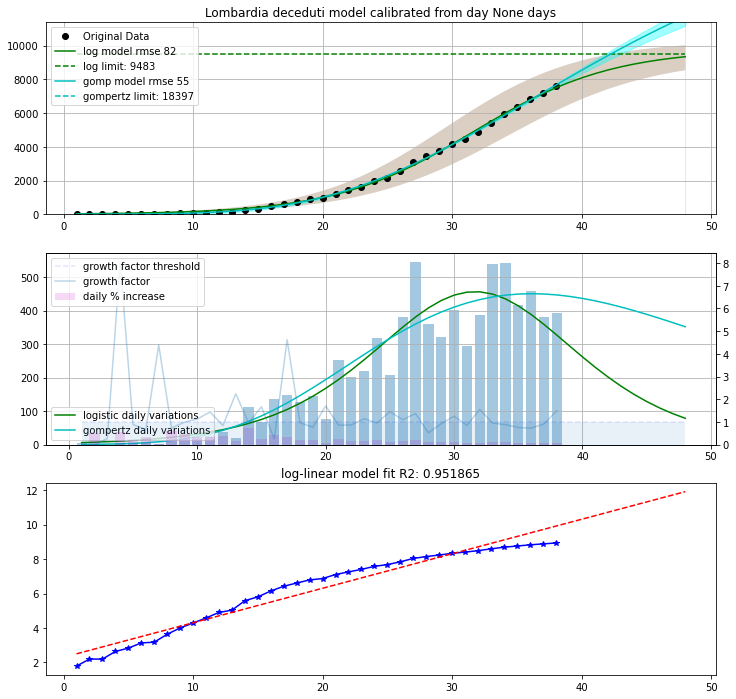

next day prediction for log model:  7815
next day prediction for gomp model:  8105
data
03/28/2020    5944
03/29/2020    6360
03/30/2020    6818
03/31/2020    7199
04/01/2020    7593
Name: deceduti, dtype: int64


In [130]:
tools.plot_model(df_reg[region][:], 'deceduti', backward_fit=None, backward_fit_gomp=None, stdev=2, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=False, label=region)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:146: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



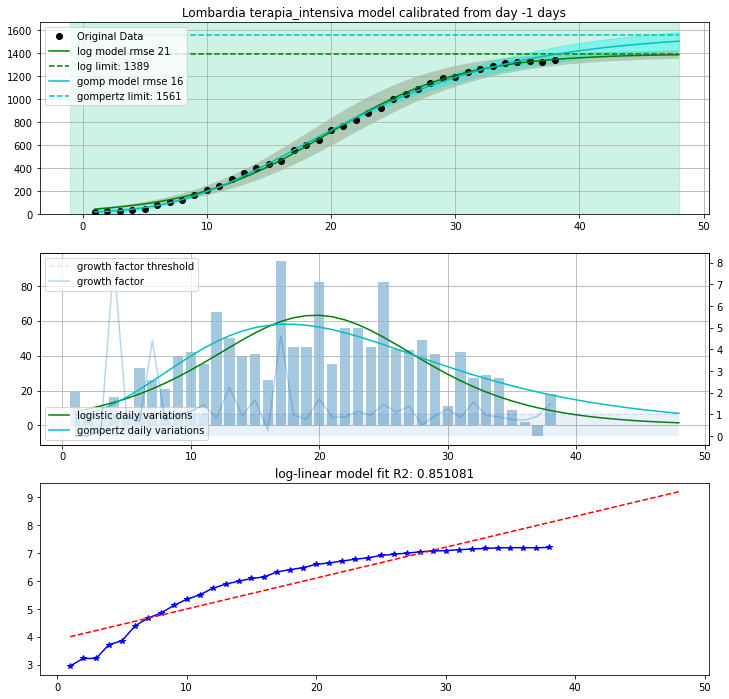

next day prediction for log model:  1354
next day prediction for gomp model:  1406
data
03/28/2020    1319
03/29/2020    1328
03/30/2020    1330
03/31/2020    1324
04/01/2020    1342
Name: terapia_intensiva, dtype: int64


In [132]:
tools.plot_model(df_reg[region], 'terapia_intensiva', backward_fit=-1, stdev=2, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=False, label = region)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:146: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



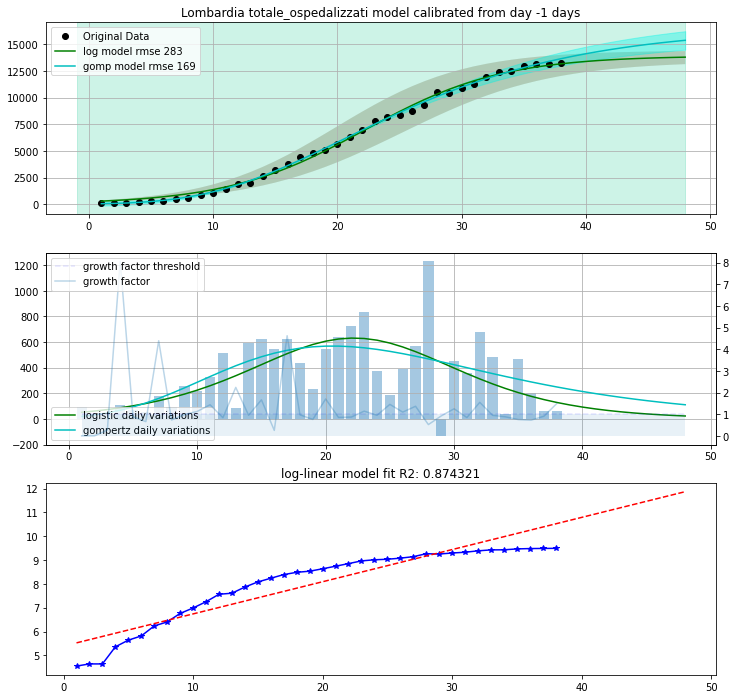

next day prediction for log model:  13303
next day prediction for gomp model:  13904
data
03/28/2020    12471
03/29/2020    12941
03/30/2020    13145
03/31/2020    13207
04/01/2020    13269
Name: totale_ospedalizzati, dtype: int64


In [133]:
tools.plot_model(df_reg[region], 'totale_ospedalizzati', backward_fit=-1, forward_look=10, plotlimit=False, stdev=2,
                 show_pol=False, show_exp=False, label=region)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:146: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



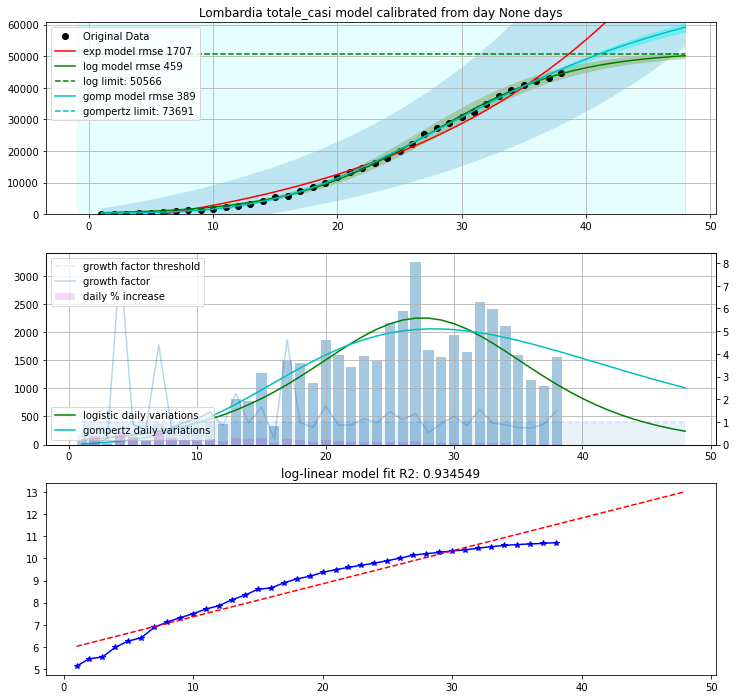

next day prediction for log model:  45461
next day prediction for gomp model:  47493
next day prediction for exp model:  51888
data
03/28/2020    39415
03/29/2020    41007
03/30/2020    42161
03/31/2020    43208
04/01/2020    44773
Name: totale_casi, dtype: int64


In [134]:
tools.plot_model(df_reg[region], 'totale_casi', backward_fit=None, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=True, label=region)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:146: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



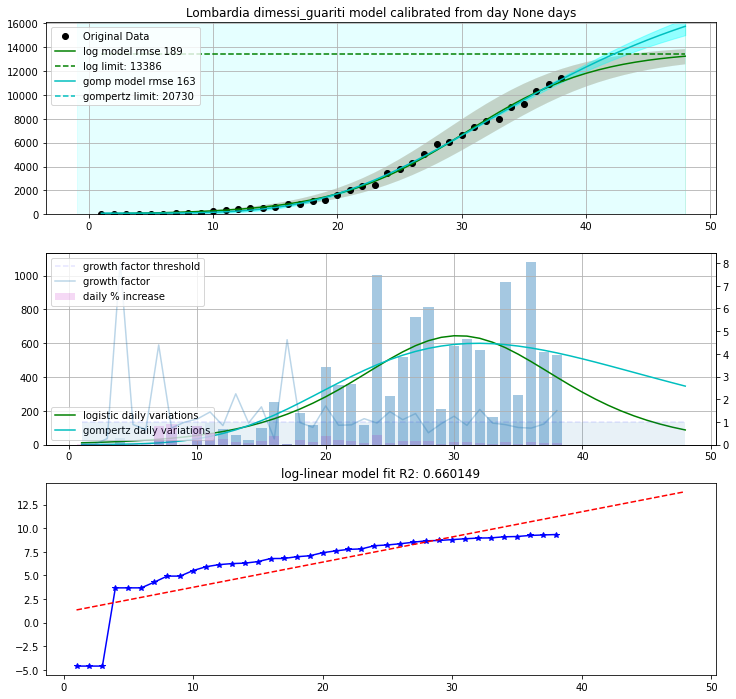

next day prediction for log model:  11472
next day prediction for gomp model:  11810
data
03/28/2020     8962.0
03/29/2020     9255.0
03/30/2020    10337.0
03/31/2020    10885.0
04/01/2020    11415.0
Name: dimessi_guariti, dtype: float64


In [135]:
tools.plot_model(df_reg[region].replace(0,0.01), 'dimessi_guariti', backward_fit=None, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=False, label=region)

### anaylsis for sum of regions different from Lombardia

In [136]:
df_centro_sud = pd.DataFrame()
exclude = ['Lombardia', 'Piemonte', 'Veneto', 'Emilia Romagna', 'Friuli Venezia Giulia', 'Liguria', 
           "Valle d'Aosta", 'P.A. Bolzano', 'P.A. Trento']
added = []
for item in df_reg:
    if item not in exclude:
        added.append(item)
        df_centro_sud = pd.concat([df_centro_sud, df_reg[item]])
df_centro_sud = df_centro_sud.reset_index().groupby('data').sum()
added

['Abruzzo',
 'Basilicata',
 'Calabria',
 'Campania',
 'Emilia-Romagna',
 'Lazio',
 'Marche',
 'Molise',
 'Puglia',
 'Sardegna',
 'Sicilia',
 'Toscana',
 'Umbria']

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:146: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



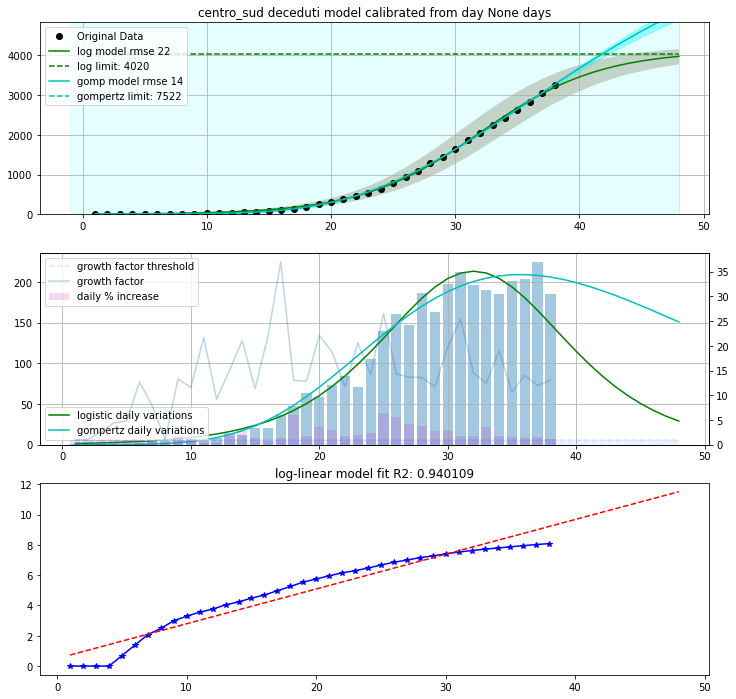

next day prediction for log model:  3334
next day prediction for gomp model:  3474
data
03/28/2020    2430
03/29/2020    2632
03/30/2020    2836
03/31/2020    3061
04/01/2020    3247
Name: deceduti, dtype: int64


In [137]:
tools.plot_model(df_centro_sud.replace(0,1), 'deceduti', backward_fit=None, stdev=2, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=False, label='centro_sud')

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

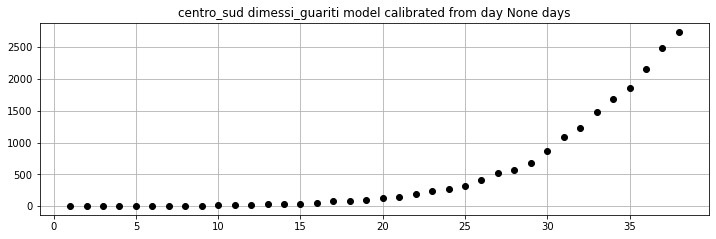

In [138]:
tools.plot_model(df_centro_sud.replace(0,0.01), 'dimessi_guariti', backward_fit=None, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=False, label='centro_sud')

In [ ]:
label = 'deceduti'
all_regions = df_reg.keys()
all_regions = ['Lombardia', 'Abruzzo', 'Piemonte', 'Toscana', 'Lazio', 'Veneto', 'Calabria', 'Campania']
reg_analysis = pd.DataFrame()
fig, ax = plt.subplots(figsize=(11,11))
for region in all_regions:
    temp = df_reg[region][label]
    temp = temp.loc[~(temp==0)].reset_index(drop=True).iloc[:-1]    
    temp.name = region
#    if region == 'Abruzzo':
#        temp.plot(kind='line', style='x-', linewidth=5, figsize=(12,12), legend=True)
#    else:
    temp.plot(kind='line', style='.-', figsize=(12,12), legend=True)
    plt.annotate(region, xy=(len(temp)-1, temp.iloc[-1]),textcoords='data',)
plt.title('regional evolution ' + label)
plt.yscale('log')
plt.ylim(bottom=0, top=10000)
plt.grid()
plt.grid(which = 'minor', b=True)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

In [139]:
popreg = pd.read_csv('../data/popitaregions.csv').set_index('Regione')

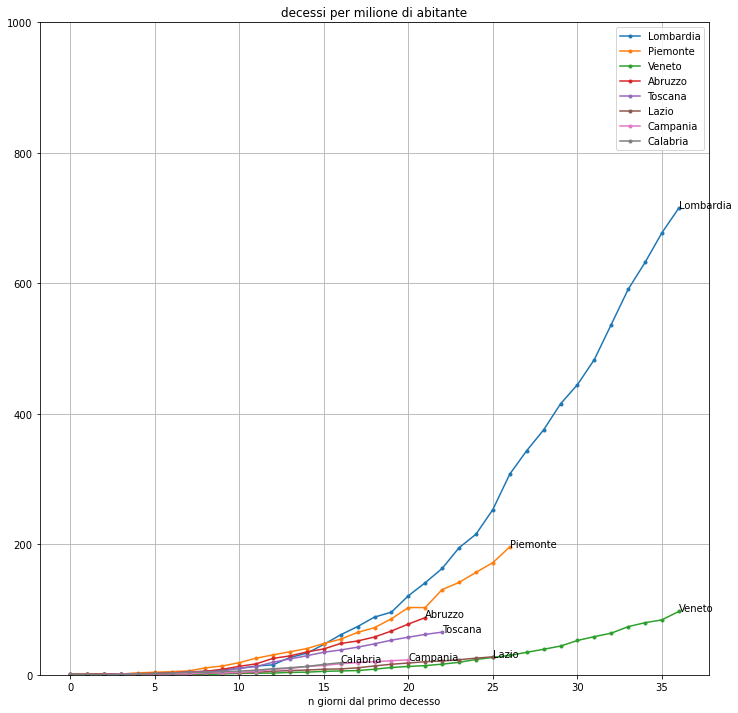

In [140]:
label = 'deceduti'
all_regions = df_reg.keys()
all_regions = ['Lombardia', 'Abruzzo', 'Piemonte', 'Toscana', 'Lazio', 'Veneto', 'Calabria', 'Campania']
topreg = {}
for region in all_regions:
    topreg[region] = df_reg[region][label].iloc[-1]
top_regions = pd.DataFrame.from_dict(topreg, orient='index')
top_regions['Popolazione'] = popreg['Popolazione']
top_regions = top_regions.fillna(popreg.loc['Trentino-Alto Adige','Popolazione']/2)
top_regions['deceduti'] = top_regions[0]/top_regions['Popolazione']*1e06
reg_analysis = pd.DataFrame()
fig, ax = plt.subplots(figsize=(11,11))
for region in top_regions.sort_values(by='deceduti', ascending=False).index[:13]:
    temp = df_reg[region][label]
    if (region == 'P.A. Bolzano') or (region == 'P.A. Trento'):
        pop = popreg.loc['Trentino-Alto Adige', 'Popolazione']/2 *1e06
    else:
        pop = popreg.loc[region, 'Popolazione']
    temp = temp.loc[~(temp==0)].reset_index(drop=True).iloc[:-1]/pop *1e06
    temp.name = region
#    if region == 'Abruzzo':
#        temp.plot(kind='line', style='x-', linewidth=5, figsize=(12,12), legend=True)
#    else:
    temp.plot(kind='line', style='.-', figsize=(12,12), legend=True)
    plt.annotate(region, xy=(len(temp)-1, temp.iloc[-1]),textcoords='data',)
plt.title('decessi per milione di abitante')
plt.xlabel('n giorni dal primo decesso')
#plt.yscale('log')
plt.ylim(bottom=0, top=1000)
plt.grid()
plt.grid(which = 'minor', b=True)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

### Lombardy evolution for provinces

c:\anaconda3\envs\coronavirus\lib\site-packages\ipykernel_launcher.py:10: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



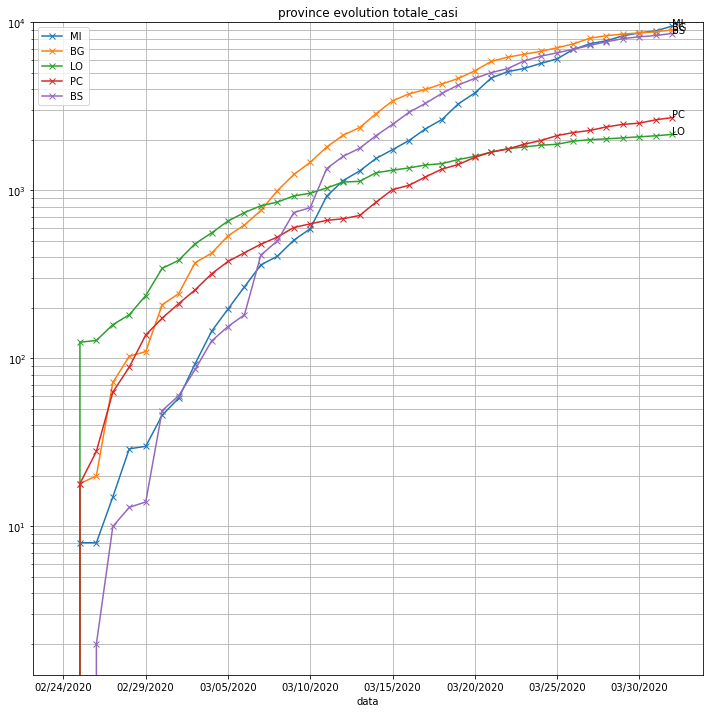

In [141]:
prov_analysis = df_prov.reset_index().pivot_table(index='data', columns='sigla_provincia', 
            values='totale_casi')[['MI', 'BG', 'LO', 'PC', 'BS']]

prov_analysis.plot(kind='line', style='x-', figsize=(12,12), legend=False)

for label in ['MI', 'BG', 'LO', 'PC', 'BS']:
    plt.annotate(label, xy=(len(prov_analysis)-1, prov_analysis[label].iloc[-1]),textcoords='data')
plt.title('province evolution totale_casi')
plt.yscale('log')
plt.ylim(bottom=0, top=10000)
plt.grid()
plt.grid(which = 'minor', b=True)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

### china comparison

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:146: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



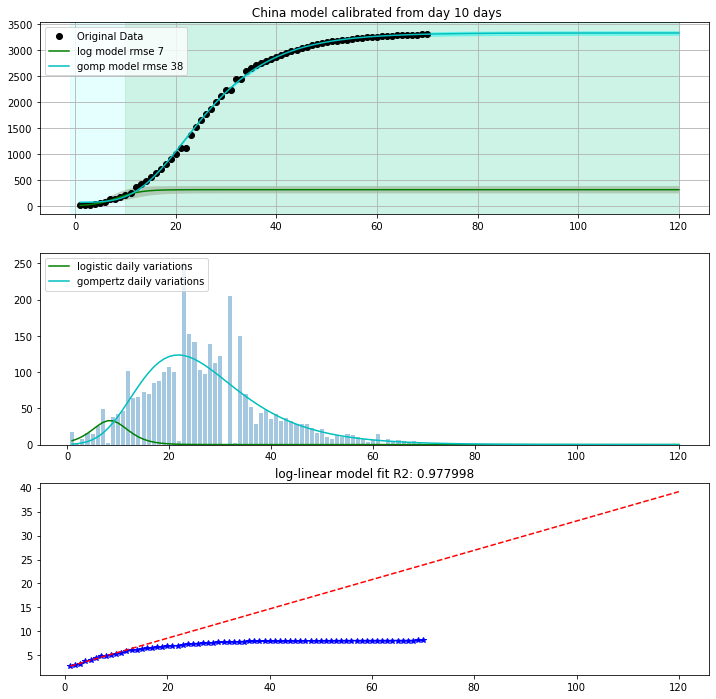

next day prediction for log model:  315
next day prediction for gomp model:  3312
2020-03-27    3296.0
2020-03-28    3299.0
2020-03-29    3304.0
2020-03-30    3308.0
2020-03-31    3309.0
Name: China, dtype: float64


In [142]:
china_deaths = df_world_deaths[df_world_deaths['Country/Region']=='China'].groupby('Country/Region').sum().drop('Lat',1).drop('Long',1).T.iloc[:-1]
china_deaths.index = pd.to_datetime(china_deaths.index)
tools.plot_model(china_deaths, 'China', backward_fit=10, forward_look=50, plotdifferential=True, plotlimit=False, show_pol=False, show_exp=False)

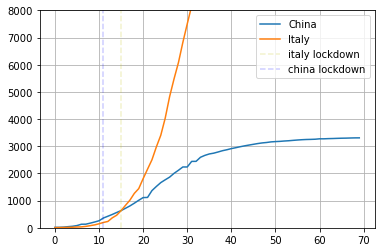

In [143]:
df_compare = pd.DataFrame(data=pd.concat([china_deaths.reset_index(drop=True), df_naz['deceduti'].reset_index(drop=True)], 
                            axis=1))
df_compare.columns = ['China','Italy']
df_compare.plot()
plt.ylim(0,8000)
plt.grid()
plt.axvline(x=15, label='italy lockdown', alpha=0.2, color='y', linestyle='--')
plt.axvline(x=11, label='china lockdown', alpha=0.2, color='b', linestyle='--')
plt.legend()

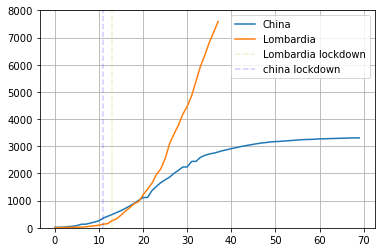

In [144]:
df_compare = pd.DataFrame(data=pd.concat([china_deaths.reset_index(drop=True), 
                    df_reg['Lombardia']['deceduti'].reset_index(drop=True)], axis=1))
df_compare.columns = ['China','Lombardia']
df_compare.plot()
plt.ylim(0,8000)
plt.grid()
plt.axvline(x=13, label='Lombardia lockdown', alpha=0.2, color='y', linestyle='--')
plt.axvline(x=11, label='china lockdown', alpha=0.2, color='b', linestyle='--')
plt.legend()

## World comparisons

In [145]:
df_world_deaths['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [146]:
countries = ['Spain', 'Italy', 'Germany', 'France', 'United Kingdom', 'US', 'Japan', 'Korea, South', 'Switzerland', 'China']
df_countries = pd.DataFrame()
df_countries_stripped = pd.DataFrame()
for country in countries:
    print(country)
    df_countries = pd.concat((df_countries, df_world_deaths.groupby('Country/Region').sum().loc[country].drop(['Lat','Long'],0).dropna()), 1)
    temp = df_world_deaths.groupby('Country/Region').sum().loc[country].drop(['Lat','Long'],0).reset_index(drop=True)    
    temp = temp.loc[~(temp==0)].reset_index(drop=True).iloc[:-1]    
    df_countries_stripped= pd.concat((df_countries_stripped,  temp), 1)
df_countries.columns = countries
#df_countries_stripped = pd.concat((pd.DataFrame(np.zeros((1,len(countries))), columns=countries), df_countries_stripped),0).reset_index(drop=True)

Spain
Italy
Germany
France
United Kingdom
US
Japan
Korea, South
Switzerland
China


In [147]:
start_dates = {}
start_dates['Spain'] = '3/3/20'
start_dates['Italy'] = '2/21/20'
start_dates['Germany'] = '3/9/20'
start_dates['France'] = '2/25/20'
start_dates['United Kingdom'] = '3/5/20'
start_dates['US'] = '3/1/20'

country_offsets = {key:0 for key in countries}

country_offsets['France'] = -10
country_offsets['United Kingdom'] = -2
country_offsets['US'] = -2
country_offsets['Japan'] = -13
country_offsets['Switzerland'] = -2

populations.loc['US'] = populations.loc['United States']
populations.loc['Korea, South'] = populations.loc['Korea, Rep.']

c:\anaconda3\envs\coronavirus\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



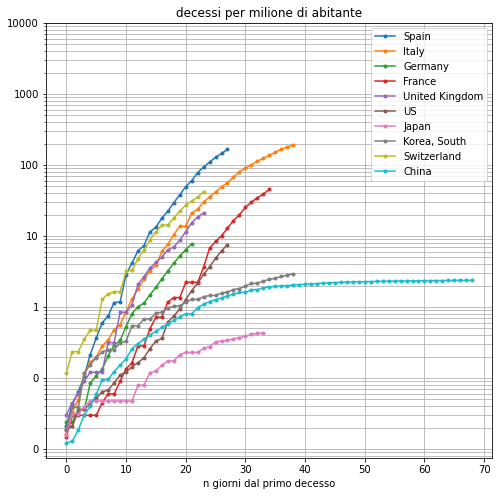

In [148]:
fig, ax = plt.subplots(figsize=(8,8))
for country in countries:
    plt.plot(df_countries_stripped[country].shift(country_offsets[country]).dropna()[:-1] / populations.loc[country] *1e6, '.-', label=country, )
    #plt.annotate(country, xy=(len(df_countries_stripped[country].dropna())-1, np.log(df_countries_stripped[country].shift(country_offsets[country]).dropna().iloc[-1])),textcoords='data')
plt.title('decessi per milione di abitante')
plt.xlabel('n giorni dal primo decesso')
plt.yscale('log')
plt.ylim(bottom=0, top=10000)
plt.grid()
plt.grid(which = 'minor', b=True)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

c:\anaconda3\envs\coronavirus\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



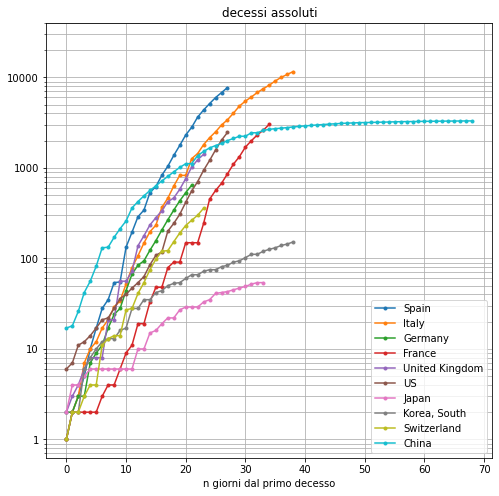

In [149]:
fig, ax = plt.subplots(figsize=(8,8))
for country in countries:
    plt.plot(df_countries_stripped[country].shift(country_offsets[country]).dropna()[:-1], '.-', label=country)
plt.title('decessi assoluti')
plt.xlabel('n giorni dal primo decesso')
plt.yscale('log')
plt.ylim(bottom=0, top=40000)
plt.grid()
plt.grid(which = 'minor', b=True)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

In [150]:
countries = ['Spain', 'Italy', 'Germany', 'France', 'United Kingdom', 'US', 'Japan', 'Korea, South', 'Switzerland', 'China']
df_countries = pd.DataFrame()
df_countries_stripped = pd.DataFrame()
for country in countries:
    print(country)
    df_countries = pd.concat((df_countries, df_world_recovered.groupby('Country/Region').sum().loc[country].drop(['Lat','Long'],0).dropna()), 1)
    temp = df_world_recovered.groupby('Country/Region').sum().loc[country].drop(['Lat','Long'],0).reset_index(drop=True)    
    temp = temp.loc[~(temp==0)].reset_index(drop=True).iloc[:-1]    
    df_countries_stripped= pd.concat((df_countries_stripped,  temp), 1)
df_countries.columns = countries
#df_countries_stripped = pd.concat((pd.DataFrame(np.zeros((1,len(countries))), columns=countries), df_countries_stripped),0).reset_index(drop=True)

Spain
Italy
Germany
France
United Kingdom
US
Japan
Korea, South
Switzerland
China


In [151]:
start_dates = {}
start_dates['Spain'] = '3/3/20'
start_dates['Italy'] = '2/21/20'
start_dates['Germany'] = '3/9/20'
start_dates['France'] = '2/25/20'
start_dates['United Kingdom'] = '3/5/20'
start_dates['US'] = '3/1/20'

country_offsets = {key:0 for key in countries}

#country_offsets['France'] = -10
#country_offsets['United Kingdom'] = -2
#country_offsets['US'] = -2
#country_offsets['Japan'] = -13
#country_offsets['Switzerland'] = -2

populations.loc['US'] = populations.loc['United States']
populations.loc['Korea, South'] = populations.loc['Korea, Rep.']

c:\anaconda3\envs\coronavirus\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



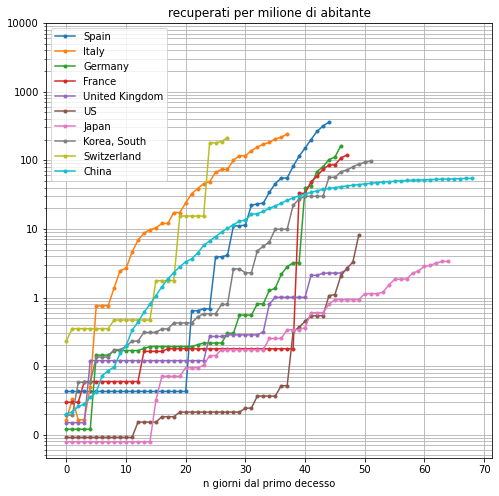

In [152]:
fig, ax = plt.subplots(figsize=(8,8))
for country in countries:
    plt.plot(df_countries_stripped[country].shift(country_offsets[country]).dropna()[:-1] / populations.loc[country] *1e6, '.-', label=country, )
    #plt.annotate(country, xy=(len(df_countries_stripped[country].dropna())-1, np.log(df_countries_stripped[country].shift(country_offsets[country]).dropna().iloc[-1])),textcoords='data')
plt.title('recuperati per milione di abitante')
plt.xlabel('n giorni dal primo decesso')
plt.yscale('log')
plt.ylim(bottom=0, top=10000)
plt.grid()
plt.grid(which = 'minor', b=True)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

c:\anaconda3\envs\coronavirus\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



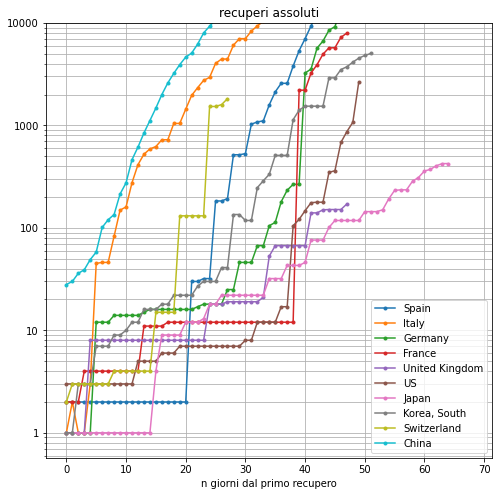

In [153]:
fig, ax = plt.subplots(figsize=(8,8))
for country in countries:
    plt.plot(df_countries_stripped[country].shift(country_offsets[country]).dropna()[:-1], '.-', label=country)
plt.title('recuperi assoluti')
plt.xlabel('n giorni dal primo recupero')
plt.yscale('log')
plt.ylim(bottom=0, top=10000)
plt.grid()
plt.grid(which = 'minor', b=True)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

c:\anaconda3\envs\coronavirus\lib\site-packages\ipykernel_launcher.py:24: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



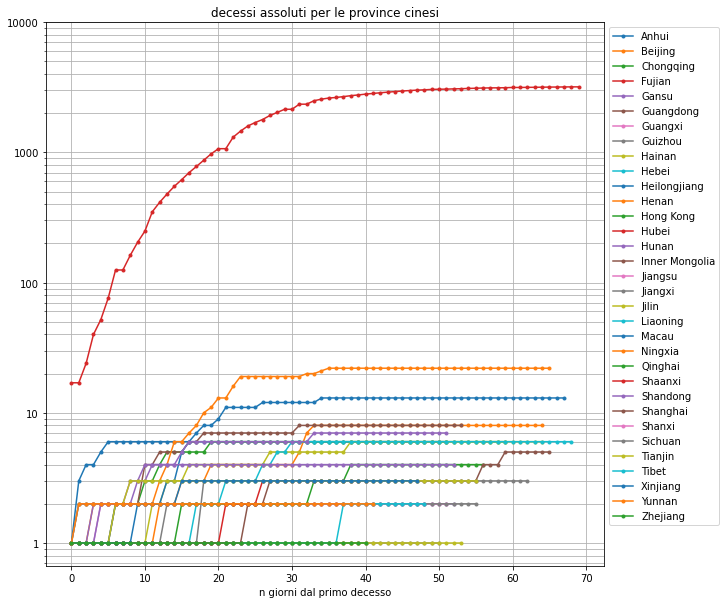

In [154]:
#regions = ['California', 'Texas', 'New Jersey', 'New York']
regions = df_world_deaths[df_world_deaths['Country/Region']=='China']['Province/State'].unique()
region_offsets = {key:0 for key in regions}

df_us_regions = pd.DataFrame()
df_us_regions_stripped = pd.DataFrame()
for region in regions:
    df_us_regions = pd.concat((df_us_regions, df_world_deaths.groupby('Province/State').sum().loc[region].drop(['Lat','Long'],0)), 1)
    temp = df_world_deaths.groupby('Province/State').sum().loc[region].drop(['Lat','Long'],0).reset_index(drop=True)    
    temp = temp.loc[~(temp==0)].reset_index(drop=True).iloc[:-1]    
    df_us_regions_stripped= pd.concat((df_us_regions_stripped,  temp), 1)
df_us_regions.columns = regions

fig, ax = plt.subplots(figsize=(10,10))
for region in regions:
    #if region == 'Hubei':
    plt.plot(df_us_regions_stripped[region].shift(region_offsets[region]), '.-', label=region)
    #    plt.legend()
    #else:
    #    plt.plot(df_us_regions_stripped[region].shift(region_offsets[region]), '.-', label='')
plt.title('decessi assoluti per le province cinesi')
plt.xlabel('n giorni dal primo decesso')
plt.yscale('log')
plt.ylim(bottom=0, top=10000)
plt.grid()
plt.grid(which = 'minor', b=True)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend(bbox_to_anchor=(1, 1))

## The SIR epidemic model

(see https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/ and 
https://www.r-bloggers.com/epidemiology-how-contagious-is-novel-coronavirus-2019-ncov/)

A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of N individuals into three "compartments" which may vary as a function of time, t:

S(t) are those susceptible but not yet infected with the disease;
I(t) is the number of infectious individuals;
R(t) are those individuals who have recovered from the disease and now have immunity to it.
The SIR model describes the change in the population of each of these compartments in terms of two parameters, β and γ. β describes the effective contact rate of the disease: an infected individual comes into contact with βN other individuals per unit time (of which the fraction that are susceptible to contracting the disease is S/N). γ is the mean recovery rate: that is, 1/γ is the mean period of time during which an infected individual can pass it on.

The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:

$dSdt=−βSI/N$ <br>
$dIdt=β(SI)/N−γI$ <br>
$dRdt=γI$ <br>

The following Python code integrates these equations for a disease characterised by parameters β=0.2, 1/γ=10days in a population of N=1000 (perhaps 'flu in a school). The model is started with a single infected individual on day 0: I(0)=1. The plotted curves of S(t), I(t) and R(t) are styled to look a bit nicer than Matplotlib's defaults.

In [28]:
# SIR model differential equations
def deriv(y, t, N, beta, gamma, theta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dDdt = theta * I
    return dSdt, dIdt, dRdt, dDdt

def SIRModel_solver(t, beta, gamma, theta):
    return SIRModel(t, beta, gamma, theta)[3] # returns just D for optimizer

def SIRModel(t, beta, gamma, theta):
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, theta))
    S, I, R, D = ret.T
    return S, I, R, D

def SIRModel_diff_ev_solver(params):
    beta, gamma, theta = params
    return np.mean(np.abs(SIRModel_solver(x_fit, beta, gamma, theta) - y_fit))

### toy example

beta:  0.2
gamma:  0.1
theta:  0.015
r0:  2.0
mean period of time of infection:  10.0


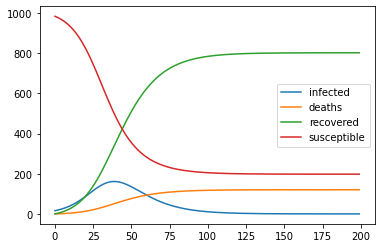

In [29]:
N = 1000 # total population Italy
I0 = 16 # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

params = (0.2, 0.1, 0.015)
S, I , R, D = SIRModel(range(200), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])

plt.plot(I, label='infected')
plt.plot(D, label='deaths')
plt.plot(R, label='recovered')
plt.plot(S, label='susceptible')
#plt.yscale('log')
#ax.yaxis.set_major_formatter(ScalarFormatter())

#plt.ylim(0,10000)
plt.legend()

### fit to official death data

calibrating with genetic algorithm...
beta:  4.0501736925186185
gamma:  3.8600677949691065
theta:  0.011472757500910369
r0:  1.0492493675363113
mean period of time of infection:  0.25906280747279037
max number of infections  68177.88189739751
max number of deaths  16630.110140566318
mae  60.22864993058761


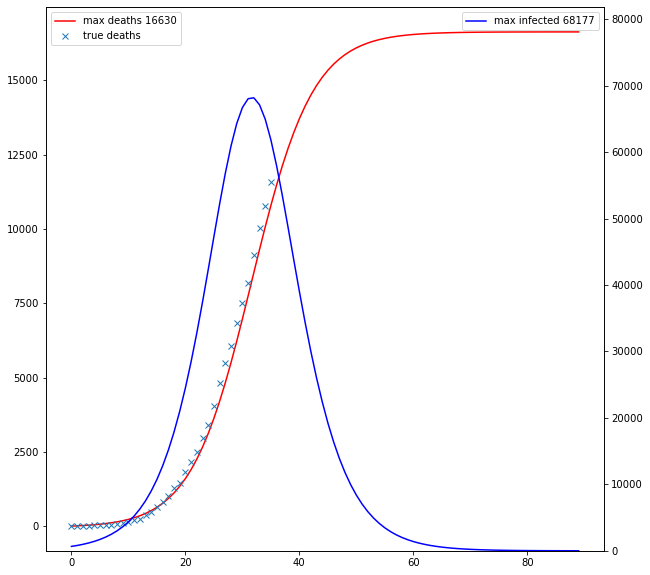

In [30]:
use_differential_evolution = True
cases_multiplier = 3
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
y_fit = df['deceduti'].values
x_fit = np.linspace(0, len(y_fit), len(y_fit))
N = 60431283 # total population Italy
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0] # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 #df['dimessi_guariti'].iloc[0] # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

bounds = [(0,5), (0, 5), (0, 5)]
if use_differential_evolution:
    print('calibrating with genetic algorithm...')
    optimization = differential_evolution(SIRModel_diff_ev_solver, bounds)
    params = optimization.x
else:
    params, covariances = curve_fit(f=SIRModel_solver, xdata=x_fit, ydata=y_fit, method='trf', bounds=bounds[0])
S, I , R, D = SIRModel(range(90), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])
print('max number of infections ', np.max(I))
print('max number of deaths ', np.max(D))
print('mae ', np.mean(np.abs(y_fit - SIRModel_solver(x_fit, *params))))
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(D,'r', label='max deaths '+str(int(np.max(D))))
ax1.plot(y_fit,'x', label='true deaths')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
plt.ylim(0,1.2*np.max(I))
ax2.plot(I,'b', label='max infected '+str(int(np.max(I))))
#ax2.plot(R,'g', label='recovered')
#ax2.plot(S,'y', label='susceptible')

ax2.legend()

calibrating with genetic algorithm...
beta:  2.670559130855131
gamma:  2.4148545646111543
theta:  0.0014141426556641935
r0:  1.1058881847342847
mean period of time of infection:  0.41410361296893355
max number of infections  287418.23357014806
max number of deaths  6564.007105420608
mae  20.015289666188046

In [28]:
df_china = pd.DataFrame()
df_china['deaths'] = df_world_deaths.groupby('Country/Region').sum().loc['China'].drop(['Lat','Long'],0)
df_china['recovered'] = df_world_recovered.groupby('Country/Region').sum().loc['China'].drop(['Lat','Long'],0)
df_china['confirmed'] = df_world_confirmed.groupby('Country/Region').sum().loc['China'].drop(['Lat','Long'],0)

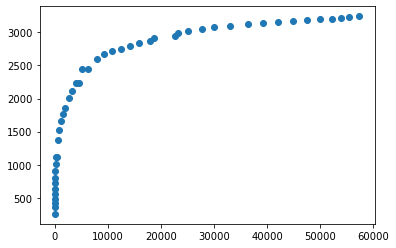

In [177]:
plt.scatter(df_china['recovered'].shift(10).drop(['pop']), df_china['deaths'].drop(['pop']))

In [173]:
pd.concat([df_china['recovered'].shift(10).drop(['pop']), df_china['recovered'].drop(['pop']), df_china['deaths'].drop(['pop'])], 1)

,recovered,recovered,deaths
1/22/20,NaN,28.0,17.0
1/23/20,NaN,30.0,18.0
1/24/20,NaN,36.0,26.0
1/25/20,NaN,39.0,42.0
1/26/20,NaN,49.0,56.0
1/27/20,NaN,58.0,82.0
1/28/20,NaN,101.0,131.0
1/29/20,NaN,120.0,133.0
1/30/20,NaN,135.0,171.0
1/31/20,NaN,214.0,213.0


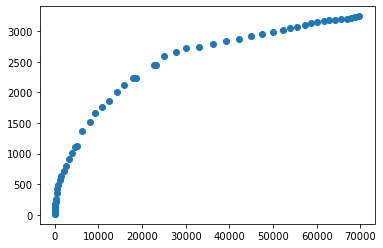

In [151]:
plt.scatter(df_china['recovered'].shift(0).drop(['pop']), df_china['deaths'].drop(['pop']))

In [127]:
import scipy.integrate as integrate
mortality_rate = 0.025
total_deaths =  integrate.quad(lambda x: SIRModel((x,), *optim_params)[1], 0, 100)[0]
print('total ', total_deaths)

total  221000.00000000006


## machine learning approach

In [73]:
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [75]:
feature_cols = ['ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati','isolamento_domiciliare', 
                'totale_positivi', 'dimessi_guariti']

In [76]:
df_X = df_naz[feature_cols].diff()
df_X = pd.concat([df_X,df_naz[feature_cols].diff(2)])
df_X['deceduti'] = df_naz['deceduti'].diff()#/df_naz['deceduti'].shift()
df_reg_feat = {}
for region in df_reg:
    df_reg_feat[region] = df_reg[region][feature_cols].diff()
    df_reg_feat[region] = pd.concat([df_reg_feat[region], df_reg[region][feature_cols].diff()])
    df_reg_feat[region]['deceduti'] = df_reg[region]['deceduti'].diff()#/df_reg[region]['deceduti'].shift()
    df_X = pd.concat([df_X, df_reg_feat[region]])
    
df_X['deceduti'] = df_X['deceduti'].shift(-1)
df_X.replace([np.inf, -np.inf], np.nan, inplace=True)
df_X.dropna(inplace=True)
df_X.index = pd.to_datetime(df_X.index)
df_X.shape

(1539, 7)

In [77]:
X = df_X[df_X.columns.difference(['deceduti'])]
y = df_X['deceduti']

#### train test split

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### time split

In [78]:
X_train = X.loc[:'03/20/2020']
X_test = X.loc['03/20/2020':]
y_train = y.loc[:'03/20/2020']
y_test = y.loc['03/20/2020':]

#### add polynomial features

In [79]:
poly = PolynomialFeatures(3)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

#### normalize data

In [80]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### linear regression

R2  0.8675183537362051
rmse  25.84172114069313
mae  19.785198740183738


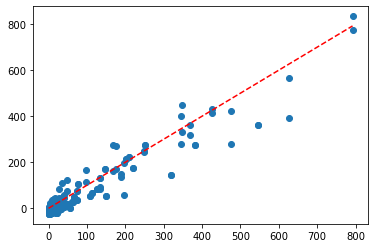

In [82]:
lr = Ridge(fit_intercept=False, normalize=False, alpha = 10.)
lr.fit(X_train, y_train)
train_pred = lr.predict(X_train)
plt.scatter(y_train, train_pred)
plt.plot(range(int(np.max(y_train))),range(int(np.max(y_train))),'r--')
print('R2 ',lr.score(X_train, y_train))
print('rmse ', np.sqrt(mean_squared_error(y_train, train_pred)))
print('mae ', mean_absolute_error(y_train, train_pred))

R2  0.12531793805675184
rmse  165.7261580697646
mae  45.504942848657564


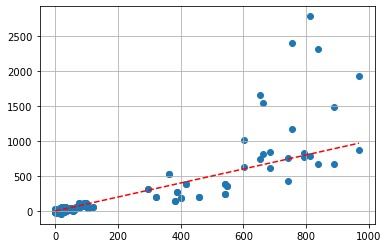

In [84]:
test_pred = lr.predict(X_test)
plt.scatter(y_test, test_pred)
plt.plot(range(int(np.max(y_test))),range(int(np.max(y_test))),'r--')
plt.grid()
print('R2 ',lr.score(X_test, y_test))
print('rmse ', np.sqrt(mean_squared_error(y_test, test_pred)))
print('mae ', mean_absolute_error(y_test, test_pred))

In [87]:
check = pd.DataFrame()
check['true'] = y_test
check['pred'] = test_pred
check['diff'] = np.abs(y_test - test_pred)

In [88]:
check

,true,pred,diff
data,,,
2020-03-20,793.0,834.139014,41.139014
2020-03-21,651.0,744.568691,93.568691
2020-03-22,601.0,634.668187,33.668187
2020-03-23,743.0,430.841691,312.158309
2020-03-24,683.0,608.502643,74.497357
...,...,...,...
2020-03-26,26.0,52.984251,26.984251
2020-03-27,49.0,47.477968,1.522032
2020-03-28,30.0,60.325728,30.325728


In [62]:
check.mean()

true    68.718182
pred    56.103495
diff    31.607174
dtype: float64

## simulation using Facebook Phrophet Model

In [127]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\anaconda3\envs\coronavirus\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Traceback (most recent call last):
  File "c:\anaconda3\envs\coronavirus\lib\site-packages\matplotlib\axis.py", line 1573, in convert_units
    ret = self.converter.convert(x, self.units, self)
  File "c:\anaconda3\envs\coronavirus\lib\site-packages\matplotlib\category.py", line 61, in convert
    unit.update(values)
  File "c:\

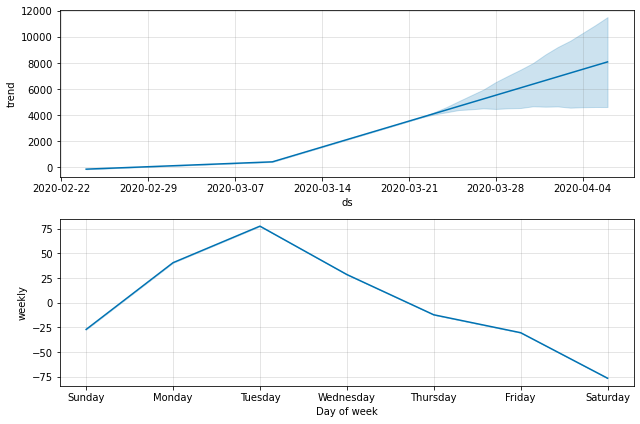

ValueError: view limit minimum -7.930656e+16 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

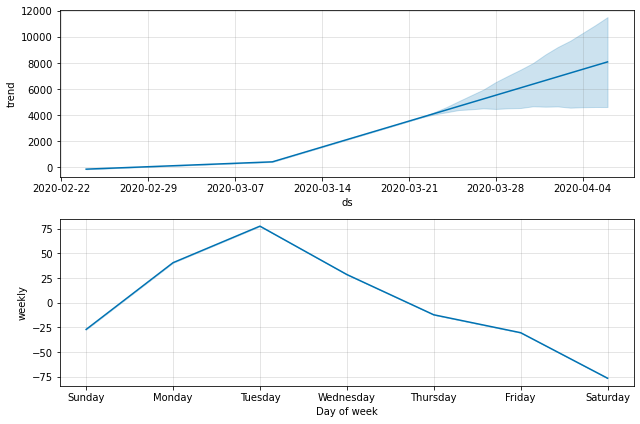

In [128]:

y = 'deceduti'
train_data = pd.DataFrame()
train_data['ds']=df_naz.index
train_data['y']=df_naz[y].reset_index(drop=True).values
growth = 'linear'
cap = 4000
floor = 0
if growth=='logistic':
    train_data['cap'] = cap
    train_data['floor'] = floor

m = Prophet(growth = growth, changepoints=['2020-03-10'], changepoint_prior_scale=0.75)
m.fit(train_data)
future = m.make_future_dataframe(periods=20)
if growth=='logistic':
    future['cap'] = cap
    future['floor'] = floor
forecast = m.predict(future)
fig = m.plot(forecast)

a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title('prophet forecast for ' + y)
plt.plot(train_data.set_index('ds')['y'],'r*',label='actual data')
#plt.axvspan(whole_data.iloc[0]['ds'], train_data.iloc[-1]['ds'], alpha=0.15, color='red', label='train period')
#plt.axvspan(test_data.iloc[0]['ds'], test_data.iloc[-1]['ds'], alpha=0.15, color='green', label='test period')
plt.legend()
m.plot_components(forecast)
